# Определение возраста покупателей

**Описание проекта:**

Целью данного проекта является создание модели для определения возраста клиентов сетевого супермаркета "Хлеб-Соль". Требуется обучить модель так, чтобы по фотографии она определила приблизительный возраст человека. Обучить модель следует на датасете [APPA-REAL](https://chalearnlap.cvc.uab.cat/dataset/26/description/).

По заданию для определения качества модели должна использоваться метрика средняя абсолютная ошибка - MAE. Ее значение не должно превышать 8, то есть модель может ошибиться в предсказании возраста покупателя не более чем на 8 лет.

**Состав проекта:**

- Исследовательский анализ данных
- Обучение и тестирование модели на внешнем сервере
- Анализ модели
- Вывод

## Исследовательский анализ данных

<h3>Загрузка данных</h3>

Для начала исследовательского анализа загрузим данные:

In [1]:
#libraries 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image

In [2]:
sns.set_context('paper')
sns.set_style('whitegrid')

In [3]:
RS = 121212

Загрузим csv файл с названиями изображний и целевым признаком:

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')

С помощью загрузчика извлечем данные из папки:

In [5]:
#loading image data with generator

datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        seed=RS
)

Found 7591 validated image filenames.


Видим, что загрузчик обнаружил 7591 изображений. Нам требуется обучить модель определять возраст, и диапазон значения возраста составляет целый век - 100 лет. Таким образом, если взять промежуток в 1 год, для качественного обучения нам стоило бы иметь порядка 1000 изображений на каждый год возраста, то есть 100 * 1000 = 100000 изображений, или, если брать по 500 на каждый год - 500 * 100 = 50000. У нас же в датасете чуть меньше 8000 изображений. 

Исходя из этого, нам следует искусственно увеличить выборку посредством применения техники аугментации - попробуем использовать отражение по горизонтали и вертикали.

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Действительно, видим по датафрейму, что у нас 7591 название картинок и ровно столько же значений возраста.

In [7]:
features, target = next(datagen_flow)

In [8]:
features.shape

(32, 224, 224, 3)

In [9]:
target.shape

(32,)

In [10]:
target

array([60, 48,  4, 30,  8,  5, 51, 17, 20, 48, 23, 30, 35, 16, 50, 57,  1,
       40, 30, 32, 20,  4, 19, 23, 35,  2, 40, 19, 50, 30,  2, 43])

Итак, в признаках `features` мы получили четырехмерный тензор, в котором 32 изображения размером 224 на 224 пикселя с тремя цветовыми каналами. 

В целевом признаке `target` мы получили одномерный массив с возрастом людей на соответствующих изображениях.

<h3>График распределения возраста в выборке</h3>

Посмотрим сначала описательную статистику по возрасту:

In [11]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Получается, что минимальное значение возраста - это 1 год. Интересно посмотреть на возраст от 1 до 10 лет, чтобы убедиться, что там есть правильные изображения. 

Максимальное значение составляет 100 лет. Таким образом, в датасете размах возраста - это целый век.

Для построения графика используем колонку целевого признака `real_age` из датафрейма:

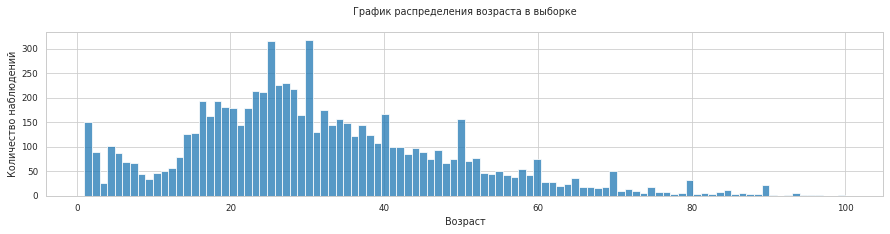

In [12]:
plt.figure(figsize=(15, 3))
sns.histplot(x='real_age', data=labels, bins=100)
plt.title('График распределения возраста в выборке\n')
plt.xlabel('Возраст')
plt.ylabel('Количество наблюдений')
plt.show()

Гистограмма показывает, что распределение близко к нормальному. Большая часть значений сосредоточена вокруг отметок 20-40 лет. Справа имеется вытянутый хвост (значения больше 60 лет, которых достаточно мало). Интересной особенностью распределения являются пики на круглых значениях - 20, 30, 40, 50, 60 лет и т.д. Возможно, чаще всего люди фотографируются на свой юбилей, либо склонны округлять свой возраст.

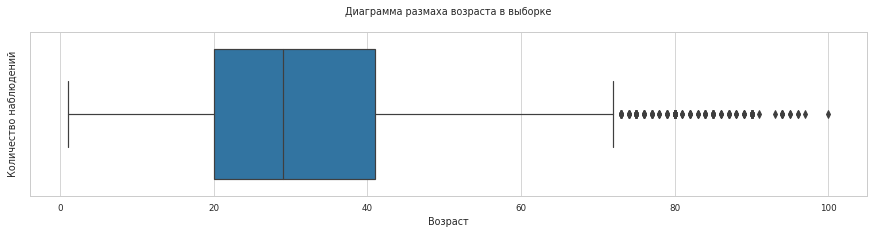

In [13]:
plt.figure(figsize=(15, 3))
sns.boxplot(x='real_age', data=labels)
plt.title('Диаграмма размаха возраста в выборке\n')
plt.xlabel('Возраст')
plt.ylabel('Количество наблюдений')
plt.show()

По диаграмме размаха видим, что значения приблизительно после 70-ти лет статистически оцениваются как выбросы, так как их мало. Эти значения - хвост на гистограмме.

In [14]:
labels.groupby('real_age').agg('count').sort_values(by='real_age', ascending=True)

,file_name
real_age,
1,149
2,88
3,25
4,101
5,87
...,...
94,5
95,2
96,2


Видим, что наблюдений в конце возрастного спектра гораздо меньше, чем в начале.


Посмотрим на фотографии людей, возраст которых составляет 1 год:

In [15]:
year_1 = labels[labels['real_age'] == 1].reset_index(drop=True).head(5)

Для этого напишем функцию для вывода изображений на экран:

In [16]:
def pictures(rows, columns, df, figsize):
    """
    takes rows, columns - integers,
          df,
          figsize - tuple
          
    returns pictures in a shape of given rows and columns
    """
    fig = plt.figure(figsize=figsize)

    for i in range(len(df)):
        fig.add_subplot(rows, columns, i+1)
        image = Image.open('/datasets/faces/final_files/'+str(df['file_name'].iloc[i]))
        plt.imshow(image)

        plt.title('Возраст: {:.0f}'.format(df['real_age'].iloc[i]))
        plt.xticks([])
        plt.yticks([])

        plt.tight_layout()

    plt.show()

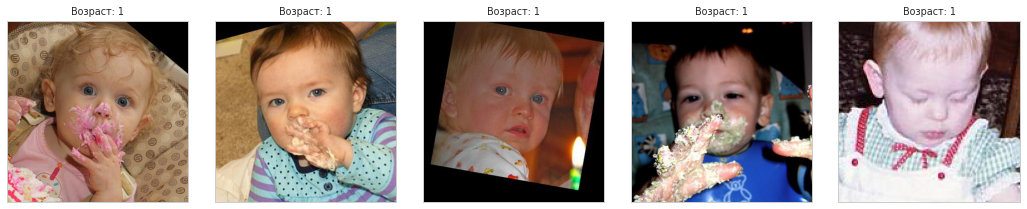

In [17]:
pictures(1, 5, year_1, (15, 3))

Отлично, фотографии действительно показывают детей одногодок. Посмотрим теперь на пятерых человек возраста от 95 до 100:

In [18]:
year_95_100 = labels.query("real_age <= 100 & real_age >= 95").reset_index(drop=True).head()

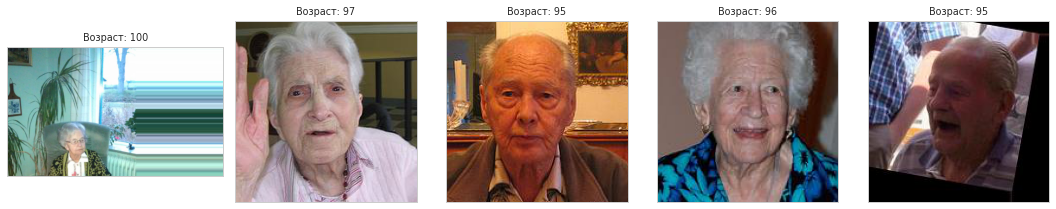

In [19]:
pictures(1, 5, year_95_100, (15, 3))

И здесь все правильно. Выведем теперь случайных 15 фотографий:

In [20]:
random_people = labels.sample(n=15, random_state=RS).reset_index(drop=True)

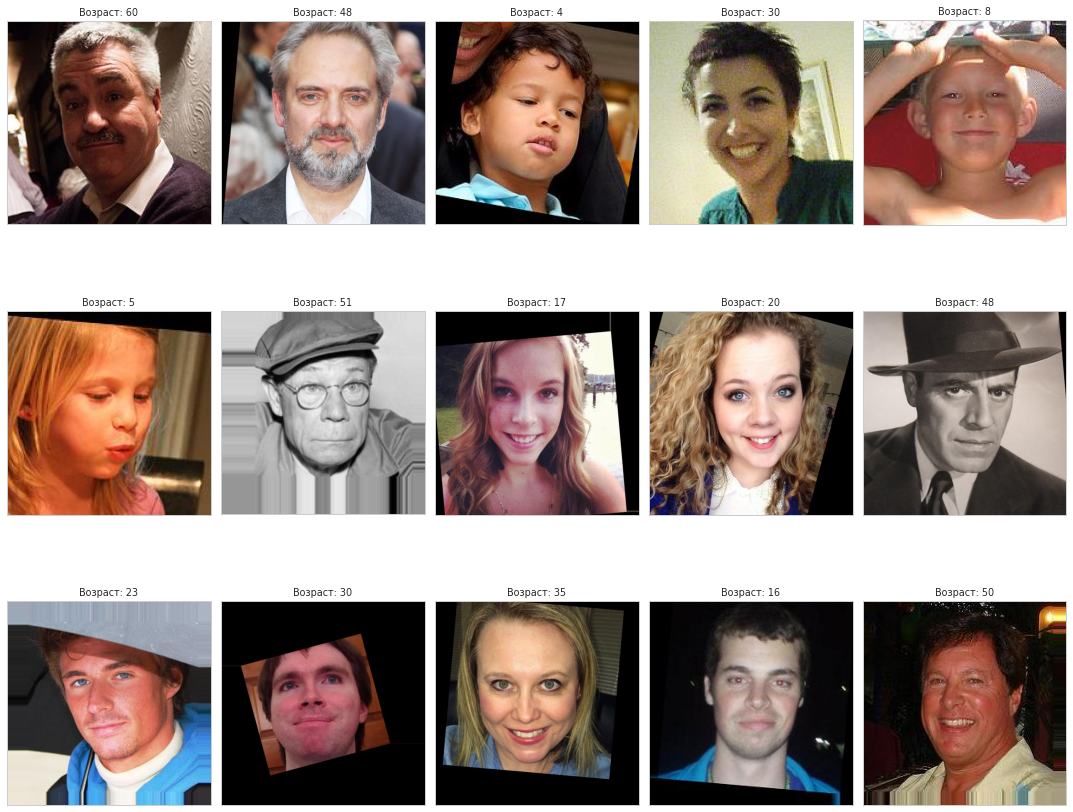

In [21]:
pictures(3, 5, random_people, (15, 15))

<h3>Вывод исследовательского анализа</h3>

В датасете представлены изображения людей разного возраста, от 1 года до 100 лет. Из гистограммы и из диаграммы размаха следует, что изображений людей старше 60-ти лет достаточно мало, поэтому, скорее всего, нейросеть не сможет хорошо обучиться, чтобы корректно определять возраст пожилых людей. Лучше всего получится определить возраст людей от 20 до 40 лет, так как половина имеющихся данных находится в этом диапазоне. Больше наблюдений у круглых возрастов.

Так как всего у нас 7591 изображение, придется применить аугментацию изображений, чтобы увеличить число признаков для обучения.

## Обучение модели

Ниже приводится код обучения модели на сервере с GPU и результат обучения:

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                 rescale=1./255,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        seed=121212, 
        subset='training'
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        seed=121212,
        subset='validation'
    )
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.00015)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-06-30 20:29:34.149528: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-30 20:29:35.196437: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 62s - loss: 247.4536 - mae: 11.4130 - val_loss: 738.6318 - val_mae: 22.1534
Epoch 2/10
178/178 - 38s - loss: 107.5241 - mae: 7.8428 - val_loss: 406.5293 - val_mae: 14.9721
Epoch 3/10
178/178 - 38s - loss: 84.8540 - mae: 6.9565 - val_loss: 219.3579 - val_mae: 11.2014
Epoch 4/10
178/178 - 38s - loss: 69.5243 - mae: 6.3062 - val_loss: 136.7763 - val_mae: 9.0250
Epoch 5/10
178/178 - 37s - loss: 57.4537 - mae: 5.7761 - val_loss: 106.8294 - val_mae: 7.6554
Epoch 6/10
178/178 - 38s - loss: 50.7214 - mae: 5.4422 - val_loss: 81.9519 - val_mae: 6.7285
Epoch 7/10
178/178 - 38s - loss: 44.7268 - mae: 5.1016 - val_loss: 96.6772 - val_mae: 7.5940
Epoch 8/10
178/178 - 38s - loss: 39.0047 - mae: 4.7673 - val_loss: 105.4811 - val_mae: 7.7489
Epoch 9/10
178/178 - 38s - loss: 34.9022 - mae: 4.4685 - val_loss: 89.5157 - val_mae: 6.9916
Epoch 10/10
178/178 - 38s - loss: 29.4758 - mae: 4.1561 - val_loss: 73.3096 - val_mae: 6.5654
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 73.3096 - mae: 6.5654
Test MAE: 6.5654


```

## Анализ обученной модели

В качестве основы модели была использована `ResNet50`, то есть Residual Network с 50 слоями. В качестве последних слоев были взяты глобальный двумерный пулинг усреднением - `GlobalAveragePooling2D()` и полносвязный слой с одним нейроном и функцией активации Rectified Linear Unit - `Dense(1, activation='relu')`, перед которым поставили `Flatten` для превращения многомерных тензоров в одномерный для передачи в полносвязный слой. Веса были загружены из предобученной модели.

Так как в датасете всего было около 8000 объектов, были применены аугментации - отражения по горизонтали и вертикали. Выборка была поделена на обучающую и тестовую в соотношении 75/25.

В процессе обучения менялись настройки скорости обучения `learning_rate` в оптимизаторе с алгоритмом Adam. Экспериментальным путем хорошо показало себя значение равное 0.00015.

Результат средней абсолютной ошибки после обучения модели на 10 эпохах составил 6.5654, что меньше, чем пороговое значение 8. Таким образом, модель успешно прошла тестирование.

<h2>Вывод</h2>

В процессе работы над данным проектом был произведен исследовательский анализ данных, в процессе которого были выдвинуты гипотезы о возможной точности предсказаний, связанной с характером распределения целевого признака - возраста. На данном этапе также была была сформирована потребность в аугментации выборки. 

Далее было произведено обучение модели нейронной сети, в основе которой использовалась архитектура ResNet50. Данная конфигурация модели с предобученными весами и небольшим подбором параметров показала метрику MAE лучшую, чем требовалась по заданию. 

Таким образом, получилось создать модель для определения возраста покупателей по их фотографиям, которая ошибается в среднем на 6.5 лет.